### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import pickle
from pathlib import Path
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mean

### Load and explore the data (4 marks)

In [2]:
# load dataset from CSV file
df = pd.read_csv("product-category-dataset-improved.csv")

# print head of dataframe to explore the data
df.head()

,Description,Level_1,Level_2,Level_3
0,gerb cap help keep littl on head cov warm day ...,09BF5150,C7E19,FDCF
1,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,ED0D
2,tut ballet anym leap foxy fash ruffl tul toddl...,09BF5150,C7E19,D06E
3,newborn inf toddl boy hoody jacket oshkosh b g...,2CEC27F1,ADAD6,98CF
4,easy keep feel warm cozy inf toddl girl hoody ...,2CEC27F1,ADAD6,3918


In [3]:
# use tail() function to see the last 5 rows of the  df for further exploration
df.tail()

,Description,Level_1,Level_2,Level_3
10634,term 10 issu on year subscriptionyo sav 75 cov...,90A8B052,C719A,1BE5
10635,term 12 issu on year subscriptionyo sav 86 cov...,90A8B052,C719A,F45B
10636,term 9 issu on year subscriptionyo sav 64 cov ...,90A8B052,C719A,A0E2
10637,term 26 issu on year subscriptionyo sav 54 cov...,90A8B052,C719A,1BE5
10638,term 12 issu on year subscriptionyo sav 60 cov...,90A8B052,C719A,A0E2


In [4]:
# using the info function to see the Dtypes  and other information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  10627 non-null  object
 1   Level_1      10639 non-null  object
 2   Level_2      10639 non-null  object
 3   Level_3      10639 non-null  object
dtypes: object(4)
memory usage: 332.6+ KB


In [5]:
# Seeing what type the values in columns have 
print(type(df.Description[0]))
print(type(df.Level_1[0]))
print(type(df.Level_2[0]))
print(type(df.Level_3[0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


I was curious in the average number of words for every row in the Description column.
So the function below seperates the  string by whitespace and counts the words of each row which is stored in a word list.
At the end the mean of the word list is calculated.

In [6]:
word_list=[]
def number_of_words(string):
    
    new_string = str(string).split()
    number_of_words = len(new_string)
    word_list.append(number_of_words)
    return word_list
for row in df.Description:
    number_of_words(row)
print(mean(word_list))    

34.75815396183852


On average 34.7 words for every row in the Description column, that is quite a lot!

In [7]:
df.shape

(10639, 4)

In [8]:
df.dtypes

Description    object
Level_1        object
Level_2        object
Level_3        object
dtype: object

In [9]:
df.describe()

,Description,Level_1,Level_2,Level_3
count,10627,10639,10639,10639
unique,9668,15,36,94
top,glory gorg col fing complet outfit express moo...,B092BA29,2D5A3,28A7
freq,24,900,797,332


The describe()  function let's me see the count of every row for every column and how many unique values each column has.

Level_1 : 15 unique values, Level_2 : 36 unique values, Level_3 : 94 unique values,

which means I will need 1 + 15 + 36 = 52 total unique  models later on.

Since the dataframe doesn't have any numeric data, I can't explore measurments like percentiles and so on. Instead I will visualize the different value counts of Level_1, Level_2 and Level_3 to see how often each unique Product class ,or label, is represented in the dataframe.

B092BA29    900
35E04739    890
AAC8EE56    890
57164AC1    875
2CEC27F1    858
09BF5150    809
EFEF723B    800
69286F45    797
96F95EEC    587
3E1E0D78    579
4C3D8686    575
4513C920    558
014303D1    511
90A8B052    506
D410C91A    504
Name: Level_1, dtype: int64

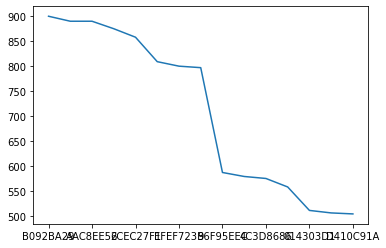

In [10]:
df['Level_1'].value_counts().plot()
df.Level_1.value_counts()

2D5A3    797
ACD06    504
C719A    482
9D9EE    462
5A8AB    450
375FE    450
B2DB4    449
CB803    448
BAE8A    448
9B69F    447
74974    447
914A1    443
390F1    441
94728    439
C7E19    429
7B638    420
A04D3    411
ADAD6    410
F4055    363
7AED7    282
02FA0    264
77F62    229
36080    176
223B2    128
5E038    118
E6162    117
E69F5    109
D5531     88
31FED     86
F824F     74
262E7     65
915D4     47
6C6B1     38
AF6B9     38
08960     24
0864A     16
Name: Level_2, dtype: int64

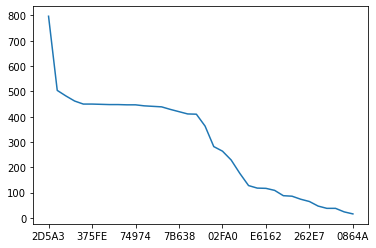

In [11]:
df['Level_2'].value_counts().plot()
df.Level_2.value_counts()

28A7    332
2CFE    225
AA6B    225
5912    220
BB6B    219
       ... 
98A8     27
74C9     26
1000     24
D55B     20
96B8     16
Name: Level_3, Length: 94, dtype: int64

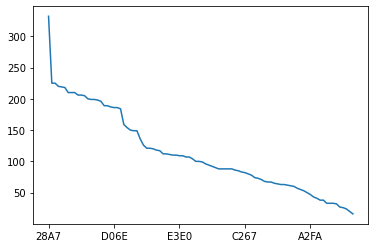

In [12]:
df['Level_3'].value_counts().plot()
df.Level_3.value_counts()

Now that I have explored the data thoroughly, I can move on to dealing with the missing data!

### Deal with Missing Data (4 marks)

In [13]:
# See  if there are missing values in columns Level_1, Level_2 and Level_3, turns out there are no missing values
print(df.Level_1.isnull().values.any())
print(df.Level_2.isnull().values.any())
print(df.Level_3.isnull().values.any())

False
False
False


In [14]:
# Check if data has missing values in the Description column, True = it has  missing values
df.Description.isnull().values.any()

True

In [15]:
# See how many rows have missing vallues in Description column
df.Description.isnull().sum().sum()

12

In [16]:
# removing rows where Description column has missing values and checking if all rows with missing values got removed
print('length of dataframe = ' +str(len(df.index)))
df.dropna(subset=['Description'], axis = 0,how='any',  inplace=True)
print('length of dataframe = ' +str(len(df.index)))

length of dataframe = 10639
length of dataframe = 10627


### Drop Classes where the number of instances is < 10 (4 marks)

In [17]:
# function for dropping classes where number of instances is < 10 by using value_counts function 
# source: https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition
def drop_classes(dataframe, column):
    value_counts = column.value_counts()
    remove = value_counts[value_counts < 10].index
    return dataframe[~column.isin(remove)]

In [18]:
# Apply to Level_1 
df = drop_classes(df, df.Level_1)

In [19]:
# Apply to Level_2 
df = drop_classes(df, df.Level_2)

In [20]:
# Apply to Level_3
df = drop_classes(df, df.Level_3)

### Now let's write a Function to Prepare Text (4 marks)
We will apply it to our DataFrame later on

* This function receives a text string and performs the following:
* Convert text to lower case
* Remove punctuation marks
* Apply stemming using the popular Snowball or Porter Stemmer (optional)
* Apply NGram Tokenisation
* Return the tokenised text as a list of strings

In [21]:
def process_text(text, n):
    """
    Takes in a string of text, then performs the following:
    1. Convert text to lower case and remove all punctuation
    2. Optionally apply stemming
    3. Apply Ngram Tokenisation
    4. Returns the tokenised text as a list
    """


    # remove punctuation from each word and convert text to lowercase
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in text if ch not in exclude)
    words = nltk.word_tokenize(s)
    words = [word.lower() for word in words]
    
    #applying stemming
    porter = PorterStemmer()
    words =[porter.stem(word) for word in words]
    
    #applying ngram tokenisation and returning processed text as list
    ngrams_1 = list(ngrams(words, n))
    output = [" ".join(ngram) for ngram in ngrams_1]
    
    return output

In [22]:
# Here is an example function call
process_text("Here we're testing the process_text function, results are as follows:",1)

['here',
 'were',
 'test',
 'the',
 'processtext',
 'function',
 'result',
 'are',
 'as',
 'follow']

In [23]:
# Results should look like this:
['here were test',
 'were test the',
 'test the processtext',
 'the processtext function',
 'processtext function result',
 'function result are',
 'result are as',
 'are as follow']

['here were test',
 'were test the',
 'test the processtext',
 'the processtext function',
 'processtext function result',
 'function result are',
 'result are as',
 'are as follow']

### Now let's apply TF-IDF to extract features from plain text (10 marks)

In [24]:
#appling process text func via a lamdba function to every row of descritpion column of the dataframe
df.Description = df.Description.map(lambda d: (process_text(d, 1)))

In [25]:
#See if the process  text function has been applied to the description column
display(df)

,Description,Level_1,Level_2,Level_3
0,"[gerb, cap, help, keep, littl, on, head, cov, ...",09BF5150,C7E19,FDCF
1,"[newborn, inf, toddl, boy, hoodi, jacket, oshk...",2CEC27F1,ADAD6,ED0D
2,"[tut, ballet, anym, leap, foxi, fash, ruffl, t...",09BF5150,C7E19,D06E
3,"[newborn, inf, toddl, boy, hoodi, jacket, oshk...",2CEC27F1,ADAD6,98CF
4,"[easi, keep, feel, warm, cozi, inf, toddl, gir...",2CEC27F1,ADAD6,3918
...,...,...,...,...
10634,"[term, 10, issu, on, year, subscriptionyo, sav...",90A8B052,C719A,1BE5
10635,"[term, 12, issu, on, year, subscriptionyo, sav...",90A8B052,C719A,F45B
10636,"[term, 9, issu, on, year, subscriptionyo, sav,...",90A8B052,C719A,A0E2
10637,"[term, 26, issu, on, year, subscriptionyo, sav...",90A8B052,C719A,1BE5


In [26]:
# Might take a while...
# Here you apply the process_text function to the Description column of the data
# Then you pass the results to the bag of words tranformer
# See here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Disable analyzer because corpus has already been tokenized
# source: https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python
vectorizer = CountVectorizer(analyzer=lambda x: x)
# use Description column as corpus
#  yok
bow = vectorizer.fit_transform(df.Description)
bow

<10627x16251 sparse matrix of type '<class 'numpy.int64'>'
	with 305194 stored elements in Compressed Sparse Row format>

Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of text file contents. Let's go ahead and check out how the bag-of-words counts for the entire corpus in a large, sparse matrix:

In [27]:
# After that you pass the result of the previous step to sklearn's TfidfTransformer
# which will convert them into a feature matrix
# See here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

transformer = TfidfTransformer()
text_tfidf = transformer.fit_transform(bow)

In [28]:
# The resulting matrix is in sparse format, we can transform it into dense
# Code prepared for you so you can see what results look like
text_tfidf = pd.DataFrame(text_tfidf.toarray())

In [29]:
# This is an example result, the matrix will contain lots of zero values, that is expected
# Some values will be non-zero
display(text_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,16241,16242,16243,16244,16245,16246,16247,16248,16249,16250
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
text_tfidf.shape

(10627, 16251)

# Now the Data is Ready for Classifier Usage

### Split Data into Train and Test sets (4 marks)

In [31]:
# Train/Test split
# use the three level columns as Y
Y = df[["Level_1","Level_2","Level_3"]]

# use 66% for training and 33% for testing
# random_state controls shuffling
X_train, X_test, y_train, y_test = train_test_split(
     text_tfidf, Y, test_size=0.33, random_state=42)

In [32]:
# You might need to reset index in each dataframe (depends on you how you do things)
# done for you to make it clearer
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [33]:
# You might need to take classes as separate columns (depends on you how you do things)
class1 = y_train['Level_1'].astype(str)
class2 = y_train['Level_2'].astype(str)
class3 = y_train['Level_3'].astype(str)

## Model training for the three levels (8 marks)

In [34]:
## Create and save model for level 1
# define name of level column and model directory
level = "Level_1"
# define name of single model to predict level 1
level1File = "0"
# path to level dir
level1Dir = Path(level)
# create level directory if it doesn't exist 
level1Dir.mkdir(exist_ok=True)

# model to train
nb = GaussianNB()
# train model with training data
nb.fit(X_train, class1)

# build path to model file and open it
with open(level1Dir.joinpath(level1File).with_suffix('.pk'), "wb") as clf:
    # serialize model and write to file
    pickle.dump(nb, clf)
    

In [35]:
## Create and save models for level 2
# define name of level column and model directory
level = "Level_2"
# path to level dir
level2Dir = Path(level)
# create level directory if it doesn't exist 
level2Dir.mkdir(exist_ok=True)

# join X and Y dataframes
xy_train = pd.concat([X_train, y_train], axis=1) 

# train model for each unique product class (=label) in Level_1 
for productClass in y_train["Level_1"].astype(str).unique():
    # select rows which contain the current productClass
    productClassRows = xy_train[xy_train["Level_1"] == productClass]
    # select all columns which contain the according TF-IDF data (=X_train) as x
    x = productClassRows.iloc[:,:-3]
    # use Level_2 column as y
    y = productClassRows["Level_2"]
    # model to train
    nb = GaussianNB()
    # train model with training data
    nb.fit(x, y)
    # build path to model file and open it
    # name of model file is current product class
    with open(level2Dir.joinpath(productClass).with_suffix('.pk'), "wb") as clf:
        # serialize model and write to file
        pickle.dump(nb, clf)

In [36]:
## Create and save models for level 3
# define name of level column and model directory
level = "Level_3"
# path to level dir
level3Dir = Path(level)
# create level directory if it doesn't exist 
level3Dir.mkdir(exist_ok=True)

# join X and Y dataframes
xy_train = pd.concat([X_train, y_train], axis=1) 

def trainModel(productClassRows):
    # define model name by concatenating Level_1 and Level_2 labels
    model_name = productClassRows["Level_1"].iloc[0]+productClassRows["Level_2"].iloc[0]
    # select all columns which contain the according TF-IDF data (=X_train) as x
    x = productClassRows.iloc[:,:-3]
    # use Level_3 column as y
    y = productClassRows["Level_3"]
    # model to train
    nb = GaussianNB()
    # train model with training data
    nb.fit(x, y)
    # build path to model file and open it
    # name of model file is Level_1 and Level_2 labels concatenated
    with open(level3Dir.joinpath(model_name).with_suffix('.pk'), "wb") as clf:
        # serialize model and write to file
        pickle.dump(nb, clf)

# group by Level_1 and Level_2 and create and train a model for each group 
xy_train.groupby(["Level_1", "Level_2"]).apply(lambda x: trainModel(x))    

""


## Predict the test set (8 marks)

In [37]:
#

def predict(tfidf_data):
    # reshape Series containing TF-IDF data to ndarray as required by GaussianNB.predict()
    reshapedData = tfidf_data.values.reshape(1, -1)
    # load Level_1 model
    level1Model = load_model(level1Dir.joinpath(level1File).with_suffix('.pk'))
    # predict Level_1 product class
    level1 = level1Model.predict(reshapedData)[0]
    # load Level_2 model based on the Level_1 prediction
    level2Model = load_model(level2Dir.joinpath(level1).with_suffix('.pk'))
    # predict Level_1 product class
    level2 = level2Model.predict(reshapedData)[0]
    # load Level_3 model based on the Level_2 prediction
    level3Model = load_model(level3Dir.joinpath(level1+level2).with_suffix('.pk'))
    # predict Level_3 product class
    level3 = level3Model.predict(reshapedData)[0]
    # return Series containing the prediction for each level
    return pd.Series([level1, level2, level3])


## Here we reload the saved models and use them to predict the levels
# load model from path
def load_model(path):
    # open file for reading
    with open(path, 'rb') as clf:
        # deserialize model
        model = pickle.load(clf)
    return model


## loop through the test data, predict level 1, then based on that predict level 2
## and based on level 2 predict level 3 (you need to load saved models accordingly)
# create prediction for each row of the test data
results = X_test.apply(lambda r: predict(r), axis=1)

In [38]:
## After you add the predictions to the results dataframe
## they should look like this
results.columns = ["Level_1_Pred", "Level_2_Pred", "Level_3_Pred"]
# Displaying the results df which contains the predicitons and displaying the y_test df which contains the actual labels
y_test.columns = ["Level_1_Actual", "Level_2_Actual", "Level_3_Actual"]
final_table = pd.concat([results, y_test], axis=1) 
display(final_table)

,Level_1_Pred,Level_2_Pred,Level_3_Pred,Level_1_Actual,Level_2_Actual,Level_3_Actual
0,3E1E0D78,E6162,2E14,D410C91A,ACD06,9203
1,09BF5150,915D4,A2FA,09BF5150,915D4,A2FA
2,2CEC27F1,BAE8A,CCEE,2CEC27F1,BAE8A,2ABA
3,57164AC1,94728,5912,57164AC1,94728,BB6B
4,57164AC1,94728,5912,57164AC1,94728,5912
...,...,...,...,...,...,...
3502,90A8B052,C719A,F45B,69286F45,2D5A3,1058
3503,014303D1,7AED7,BBA5,014303D1,7AED7,6539
3504,35E04739,B2DB4,D436,35E04739,B2DB4,D436
3505,09BF5150,C7E19,D06E,09BF5150,C7E19,224F


## Compute Accuracy on each level (4 marks)
Now you have the predictions for each level (in the test data), and you also have the actual levels, you can compute the accurcay

In [39]:
# Level 1 accuracy
# calculate accuracy from actual and predicted labels
print(accuracy_score(y_test["Level_1_Actual"], results["Level_1_Pred"]))

0.7385229540918163


In [40]:
# Level 2 accuracy
# calculate accuracy from actual and predicted labels
print(accuracy_score(y_test["Level_2_Actual"], results["Level_2_Pred"]))

0.6538351867693185


In [41]:
# Level 3 accuracy
# calculate accuracy from actual and predicted labels
print(accuracy_score(y_test["Level_3_Actual"], results["Level_3_Pred"]))

0.2600513259195894
